### Libraries

In [ ]:
pip install contractions

     |████████████████████████████████| 327kB 8.4MB/s 
     |████████████████████████████████| 286kB 42.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85404 sha256=dcf5c8521f31233a7e152e07660bc0e167d4a0cb7de26e2dee06cb005b785faf
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from google.colab import files

import re, string, unicodedata                      
import contractions                                     
from bs4 import BeautifulSoup                          
import nltk 
nltk.download('stopwords')  
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
seed = 123789

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


### Choose File

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Tweets.csv to Tweets.csv
User uploaded file "Tweets.csv" with length 3421431 bytes


In [ ]:
data = pd.read_csv('/content/Tweets.csv')

### Shape and Info on data

In [ ]:
print('Shape of train set: ', data.shape)

Shape of train set:  (14640, 15)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Replace Contractions

In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you have added commercials...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I did not today... Must mean I ...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it is really aggressive to blas...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it is a really big bad thin...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Remove Numbers

In [ ]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you have added commercials...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I did not today... Must mean I ...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it is really aggressive to blas...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it is a really big bad thin...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Split into X and Y

In [ ]:
X = data.iloc[:,10]
y = data.iloc[:,1]

In [ ]:
X.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you have added commercials...
2    @VirginAmerica I did not today... Must mean I ...
3    @VirginAmerica it is really aggressive to blas...
4    @VirginAmerica and it is a really big bad thin...
Name: text, dtype: object

### Clean Tweets

In [ ]:
cleanTweets = []

for tweet in range(0, len(X)):  
    # Remove all the special characters
    cleanTweet = re.sub(r'\W', ' ', str(X[tweet]))
 
    # remove all single characters
    cleanTweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleanTweet)
 
    # Remove single characters from the start
    cleanTweet = re.sub(r'\^[a-zA-Z]\s+', ' ', cleanTweet) 
 
    # Substituting multiple spaces with single space
    cleanTweet= re.sub(r'\s+', ' ', cleanTweet, flags=re.I)
 
    # Removing puntuations
    cleanTweet = re.sub(r'[^\w\s]', '', cleanTweet)

    # Removing prefixed 'b'
    cleanTweet = re.sub(r'^b\s+', '', cleanTweet)
 
    # Converting to Lowercase
    cleanTweet = cleanTweet.lower()
 
    cleanTweets.append(cleanTweet)

In [ ]:
cleanTweets

[' virginamerica what dhepburn said ',
 ' virginamerica plus you have added commercials to the experience tacky ',
 ' virginamerica did not today must mean need to take another trip ',
 ' virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 ' virginamerica and it is really big bad thing about it',
 ' virginamerica seriously would pay flight for seats that did not have this playing it is really the only bad thing about flying va',
 ' virginamerica yes nearly every time fly vx this ear worm will not go away ',
 ' virginamerica really missed prime opportunity for men without hats parody there https co mwpggrezp',
 ' virginamerica well did not but now do d',
 ' virginamerica it was amazing and arrived an hour early you are too good to me ',
 ' virginamerica did you know that suicide is the second leading because of death among teens ',
 ' virginamerica lt pretty graphics so much better than minimal iconography d',
 ' v

### Use TF-IDF vectorizer

In [ ]:
vectorizer = TfidfVectorizer (max_features=2500,min_df=5, max_df=0.7,stop_words=stopwords.words('english'))
cleanTweets = vectorizer.fit_transform(cleanTweets).toarray()

In [ ]:
cleanTweets.shape

(14640, 2500)

### Split into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleanTweets, y, test_size=0.2, random_state=seed)

### RF model

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=100, random_state=seed)  
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123789,
                       verbose=0, warm_start=False)

In [ ]:
predictions = text_classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

[[1714   88   42]
 [ 320  236   55]
 [ 146   64  263]]
              precision    recall  f1-score   support

    negative       0.79      0.93      0.85      1844
     neutral       0.61      0.39      0.47       611
    positive       0.73      0.56      0.63       473

    accuracy                           0.76      2928
   macro avg       0.71      0.62      0.65      2928
weighted avg       0.74      0.76      0.74      2928

0.7558060109289617


### Word Cloud

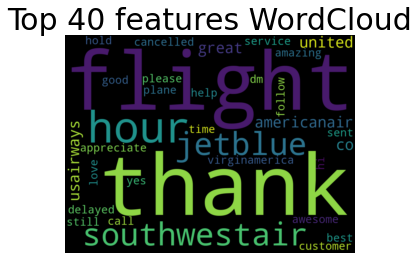

In [ ]:

all_features = vectorizer.get_feature_names()                                #Instantiate the feature from the vectorizer
Top_features=''                                                              #Addition of top 40 feature into top_feature after training the model
feat=text_classifier.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    Top_features+=all_features[i]
    Top_features+=' '
    
  
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="Black",width=1000, 
                          height=750).generate(Top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(30, 30), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=30)
plt.axis("off")
plt.show()

Random Forest classification model gives an accuracy of about 76% in the classification of tweets. We have used minimum and maximum document frequency and a max words of 2500. We can play around with this number and see we get a better score with Random Forest

In [ ]:
twitter_sentiment = Pipeline([('CVec', CountVectorizer(CountVectorizer(stop_words='english'))),
                     ('Tfidf', TfidfTransformer()),
                      ('norm', Normalizer()),
                    ('tSVD', TruncatedSVD(n_components=100)),
                     ('lgb', LGBMClassifier(n_jobs=-1))])

In [ ]:
cv_pred = cross_validate(twitter_sentiment, 
data['text'], 
data['airline_sentiment'], 
cv=5, 
scoring=('roc_auc_ovr'))

In [ ]:
sorted(cv_pred.keys())

['fit_time', 'score_time', 'test_score']

In [ ]:
cv_pred['test_score']

array([0.85208651, 0.85088562, 0.79014787, 0.86117767, 0.84005841])

Using LGBM we have achieved AUC score between 79% and 86% in classification of the tweets